# DonorsChoose.org Recommender
**Author - Rishabh Jain**

DonorsChoose.org has funded over 1.1 million classroom requests through the support of 3 million donors, the majority of whom were making their first-ever donation to a public school. If DonorsChoose.org can motivate even a fraction of those donors to make another donation, that could have a huge impact on the number of classroom requests fulfilled. A good solution will enable DonorsChoose.org to build targeted email campaigns recommending specific classroom requests to prior donors.

In [1]:
import warnings
warnings.simplefilter('ignore')

import os
import pickle
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from tqdm._tqdm_notebook import tqdm_notebook
from scipy import sparse
from wordcloud import WordCloud, STOPWORDS 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
sns.set_style('whitegrid')
tqdm_notebook.pandas()

## Loading dataset

In [2]:
start=time.time()
donations=pd.read_csv("data/Donations.csv")
donors=pd.read_csv("data/Donors.csv")
projects=pd.read_csv("data/Projects.csv")
schools=pd.read_csv("data/Schools.csv")
print("Time taken to load data : {:.2f} seconds".format(time.time()-start))

Time taken to load data : 46.06 seconds


## Pre-processing

In [3]:
dfs={
    "donations":donations,
    "donors":donors,
    "projects":projects,
    "schools":schools
}

for name,df in dfs.items():
    columns=df.columns
    print("\n## "+name.upper())
    print('-'*70)
    print('{0}{1}{2}'.format("Column Name".ljust(40),"Total".ljust(20),"Null".ljust(10)))
    print('-'*70)
    for column in columns:
        total=str(df[column].shape[0])
        nulls=str(df[column].isnull().sum())
        print('{0}{1}{2}'.format(column.ljust(40),total.ljust(20),nulls.ljust(10)))
    print()


## DONATIONS
----------------------------------------------------------------------
Column Name                             Total               Null      
----------------------------------------------------------------------
Project ID                              4687884             0         
Donation ID                             4687884             0         
Donor ID                                4687884             0         
Donation Included Optional Donation     4687884             0         
Donation Amount                         4687884             0         
Donor Cart Sequence                     4687884             0         
Donation Received Date                  4687884             0         


## DONORS
----------------------------------------------------------------------
Column Name                             Total               Null      
----------------------------------------------------------------------
Donor ID                                2122640    

### Sampling for Proof-of-Concept
For POC, we are choosing a small subset from the entire dataset. This way we will be able to train, validate and test the models really fast. It is recommended to use the entire dataset for training while deploying in production for better recommendations.

In [4]:
dataset_size=50000
donations=donations.sample(n=dataset_size,random_state=42)
donors=donors[donors['Donor ID'].isin(donations['Donor ID'])]
projects=projects[projects['Project ID'].isin(donations['Project ID'])]
print('Donations shape\t\t{}'.format(donations.shape))
print('Donors shape\t\t{}'.format(donors.shape))
print('Projects shape\t\t{}'.format(projects.shape))

Donations shape		(50000, 7)
Donors shape		(42181, 5)
Projects shape		(45863, 18)


### Merging datasets
- Left join on `projects` and `schools`
- Left join on `donations` and `donors`

In [5]:
projects=pd.merge(projects,schools,on='School ID',how='left')
donations=pd.merge(donations,donors[['Donor ID','Donor Is Teacher']],on='Donor ID',how='left')

### Filtering donations by donor who are not teacher
Our recommendation engine should be recommending donors who are not teachers. This is why we should supply only those donations for training model where donor is not a teacher.

In [6]:
donations.groupby('Donor Is Teacher').size().to_frame(name='count')

,count
Donor Is Teacher,
No,35604
Yes,14343


In [7]:
donations=donations[donations['Donor Is Teacher']=='No']
donors=donors[donors['Donor ID'].isin(donations['Donor ID'])]
projects=projects[projects['Project ID'].isin(donations['Project ID'])]
print('Donations shape\t\t{}'.format(donations.shape))
print('Donors shape\t\t{}'.format(donors.shape))
print('Projects shape\t\t{}'.format(projects.shape))

Donations shape		(35604, 8)
Donors shape		(32350, 5)
Projects shape		(33586, 26)


### Eliminating Projects with no information
Before we move further, we should check if all the `Project ID` in **donations** dataset are present in **projects** dataset. Such difference from both the sets should be removed from the **donations** dataset, because we cannot trace back the project details to build a donor profile.

In [8]:
common_project_ids=list(set(donations["Project ID"]).intersection(set(projects["Project ID"])))
donations=donations[donations["Project ID"].isin(common_project_ids)]
projects=projects[projects["Project ID"].isin(common_project_ids)]
donors=donors[donors['Donor ID'].isin(donations['Donor ID'])]
print('Donations shape\t\t{}'.format(donations.shape))
print('Donors shape\t\t{}'.format(donors.shape))
print('Projects shape\t\t{}'.format(projects.shape))

Donations shape		(35136, 8)
Donors shape		(31928, 5)
Projects shape		(33586, 26)


### Setting new indices

In [9]:
donors=donors.set_index('Donor ID')
projects=projects.set_index('Project ID')
donations=donations.set_index(['Donor ID','Project ID'])

### Unique (Donor,Project) Transformation & Log Transformation
Here, we will aggregate the donations where a single donor donated to same project more than once. Such donations will grouped by `Donor ID` and `Project ID`, and `Donation Amount` will be summed.

In [10]:
def log_transformation(x):
    return np.log(x+1)

donations['Log Amount']=donations['Donation Amount']
donations=donations.groupby(level=['Donor ID','Project ID'])['Log Amount']\
    .sum()\
    .progress_apply(log_transformation).to_frame()
donations.head()

,,Log Amount
Donor ID,Project ID,
0000a2175753bc165e53c408589a3bd6,2fc5b57c1a29c7489b182e8c49c0621b,3.258097
00014d846426ac502c555c2c28a0ef63,f80a019ef864b2778c599c2a3b106c81,5.525453
00024e86676fc2c3b317e0166ffa4768,c9febf1ce32e316a6c3f58438b567333,3.931826
0002b674d10ab80873a6665b0e472dce,d94fdd5242f3dbd1952bb08fec48c6f4,2.397895
0005217360eaad75db1d28837bd15658,59ee35cef81b61bd8eea56cef5570318,4.615121


In [11]:
print("Donations Shape\t\t{}".format(donations.shape))
print("Donors Shape\t\t{}".format(donors.shape))
print("Projects Shape\t\t{}".format(projects.shape))

Donations Shape		(34994, 1)
Donors Shape		(31928, 4)
Projects Shape		(33586, 25)


### Train & test split

In [12]:
donations_train,donations_test=train_test_split(donations,test_size=0.2,random_state=42)
donor_train_ids=donations_train.index.get_level_values(0)
donations_test=donations_test[donations_test.index.get_level_values(0).isin(donor_train_ids)]
print('Donations Train Shape\t{}'.format(donations_train.shape))
print('Donations Test Shape\t{}'.format(donations_test.shape))

Donations Train Shape	(27995, 1)
Donations Test Shape	(807, 1)


In [13]:
project_train_ids=donations_train.index.get_level_values(1).unique()
project_test_ids=donations_test.index.get_level_values(1).unique()
projects_train= projects.loc[project_train_ids]
projects_test = projects.loc[project_test_ids]
print('Projects Train Shape\t{}'.format(projects_train.shape))
print('Projects Test Shape\t{}'.format(projects_test.shape))

Projects Train Shape	(27088, 25)
Projects Test Shape	(807, 25)


## Building Recommendation Engine
We will try two main approaches for building a recommendation engine :
1. Content based filtering
2. Collaborative filtering

### Content based filtering
In this approach, we will recommend the list of donors for a new project based on the project similarity between the new project and the existing projects serveral donors has donated to in the past. Here the project similarity is identified by the taking a look at the content of project attributes like :
- Project Title
- Project Essay
- Project Need Statement

#### Training Steps
1. First, we will develop a vocabulary from all the existing projects.
2. Then we will represent each project with a vector of numbers. Index of each number in this vector will represent the presence of that word from vocbulary. This will be done using [TF-IDF](http://www.tfidf.com/) vectorizer. We will call such vector ***Project Profile*** ($PP$).
3. Next, we will build the ***Donor Profile*** ($DP$) based on the projects donor has donated to. This will be done by calculating the weighted average of project profiles and the log of their donation amounts ($DA$).

$$DP=\frac{PP_1\times log(DA_1)+PP_2\times log(DA_2)+...+PP_n\times log(DA_n)}{log(DA_1)+log(DA_2)+...+log(DA_n)}$$

4. Finally, all the donors profiles will then be stored as a pickle file for making prediction.

#### Predicting Steps
1. In order to recommend the list of most relevant donors for a new project, we will first create its project profile using the same vocabulary.
2. And then we will find the cosine similarity between the new project profile and all the donor profiles stored. This will be a vectorized implmentation otherwise recommendation will take way too long.
3. From the second step, we will get a list of similarity scores between the new project and the project interests of all the donors.
4. We will then simply choose the top N donors with high similarity score.

In [14]:
class ContentBasedRecommender:

    def __init__(self):
        '''
        projects: Dataframe indexed by project ID
        donations: Dataframe indexed by donor ID & project ID
        '''
        self.model_name='ContentBased'
        self.project_attributes=[
            "Project Title",
            "Project Need Statement",
            "Project Essay"
        ]
        self.lspace=40

    def build_project_profiles(self):
        '''Text vectorizes all the projects'''
        num_projects=self.projects.shape[0]
        print('-> Building {} project profiles...'.
              format(num_projects).ljust(self.lspace),end='')
        start=time.time()
        text_corpus=''
        for attribute in self.project_attributes:
            self.projects[attribute]=self.projects[attribute].astype(str)
            self.projects[attribute].fillna('',inplace=True)
            text_corpus+=' '+self.projects[attribute]
        self.vectorizer=TfidfVectorizer(
            strip_accents='unicode',
            analyzer='word',
            lowercase=True,
            stop_words='english',
            max_df=0.9,
            token_pattern=r'(?u)\b[A-Za-z]+\b'
        )
        project_profiles=self.vectorizer.fit_transform(text_corpus)
        end=time.time()
        print('[{:.2f}s]'.format(end-start))
        return project_profiles
    
    def build_donor_profiles(self,donor_ids):
        '''
        Builds the donor profiles based on the weighted average 
        of project profile they donated to and the logarthimic 
        of their donation amounts.
        '''
        project_ids=self.projects.index.to_list()
        print('-> Building {} donor profiles...'.
              format(len(donor_ids)).ljust(self.lspace))
        donor_profiles=[]
        for donor_id in tqdm_notebook(donor_ids):
            donor_projects=self.donations.loc[donor_id]
            idx=[project_ids.index(project_id) for project_id in donor_projects.index]
            project_profiles=self.project_profiles[idx]
            log_amounts=donor_projects.values
            donor_profile=np.sum(project_profiles.multiply(log_amounts),axis=0)/(np.sum(log_amounts)+1)
            donor_profile=sparse.csr_matrix(normalize(donor_profile))
            donor_profiles.append(donor_profile)
        donor_profiles=sparse.vstack(donor_profiles)
        return donor_profiles
        
    def fit(self,projects,donations,save_to='models'):
        '''
        Builds the donor profiles along with its donor id 
        in a pickle file.
        '''
        self.projects=projects
        self.donations=donations
        self.donor_ids=self.donations.index.get_level_values(0).unique()
        num_donors=len(self.donor_ids)
        filename=self.model_name+'{}.pickle'.format(num_donors)
        model_filepath=os.path.join(save_to,filename)
        if not os.path.exists(save_to):
            os.makedirs(save_to)    
        if os.path.isfile(model_filepath):
            model=pickle.load(open(model_filepath,"rb"))
            self.vectorizer=model[0]
            self.donor_ids=model[1]
            self.donor_profiles=model[2]
            print('-> Model loaded from {}'.format(model_filepath))
        else:
            self.project_profiles=self.build_project_profiles()
            self.donor_profiles=self.build_donor_profiles(self.donor_ids)
            model=(self.vectorizer,self.donor_ids,self.donor_profiles)
            pickle.dump(model,open(model_filepath,"wb"))   
            print('-> Model saved to {}'.format(model_filepath))
        self.feature_names=self.vectorizer.get_feature_names()
            
    def predict(self,new_project,cut_off_percentile=99.99):
        '''
        Returns the list of Donor IDs whose similarity score is 
        greater than {score_threshold} defined. Similarity score
        range is greater than 0 and less than 1.
        '''
        print('-> Predicting donors for new project...'.ljust(self.lspace),end='')
        start=time.time()
        text=''
        for attribute in self.project_attributes:
            value=new_project[attribute]
            value='' if type(value)==float else value
            text+=value
        project_profile=normalize(self.vectorizer.transform([text]))
        similarity_scores=cosine_similarity(project_profile,self.donor_profiles).reshape(-1).astype(np.object)
        recommended_donors=np.column_stack((self.donor_ids,similarity_scores))        
        cut_off=np.percentile(similarity_scores,cut_off_percentile)
        recommended_donors=recommended_donors[recommended_donors[:,1]>cut_off]
        recommended_donors=recommended_donors[recommended_donors[:,1].argsort()[::-1]]   
        recommended_donors=pd.DataFrame(
            recommended_donors,
            columns=['Donor ID','Score']
        )
        end=time.time()
        print('[{:.2f}s]'.format(end-start))
        return recommended_donors

In [15]:
recommender1=ContentBasedRecommender()
recommender1.fit(projects_train,donations_train)

-> Model loaded from models\ContentBased25775.pickle


#### Recommended Donors
Let's take a look at a new project from `projects_test` set and its donors recommended by Content Based recommender. Donors are recommended if the similarity score is greater than cut-off decided by the given cut-off percentile. Cut-off percentile is set to 99.99% in this case.

In [16]:
def donors_word_cloud(recommender,donor_id,score=None):
    '''
    This function will draw the word cloud based
    on word frequencies from projects, a donor has
    donated to.
    '''
    index=list(recommender.donor_ids).index(donor_id)
    donor_profile=recommender.donor_profiles[index]
    donor_profile=donor_profile.toarray().reshape(-1)
    feature_names=recommender.feature_names
    frequencies=dict(list(zip(feature_names,donor_profile)))
    wordCloud=WordCloud(
        width=1600,height=800,
        max_font_size=200,max_words=2000,
        mode='RGBA',background_color='black',
    ).generate_from_frequencies(frequencies)
    plt.figure(figsize=(10,8))
    title='Donor: {}'.format(donor_id)
    title+=', Score: {:.4f}'.format(score) if score else ''
    plt.title(title,fontsize=20)
    plt.imshow(wordCloud,interpolation='bilinear')
    plt.axis("off")

-> Predicting donors for new project... [0.16s]


Project ID,710f6cf814f9626f3b782235377e897a
Project Title,Chorus Risers for Fine Musicians in Poverty
Project Need Statement,My students need risers for Chorus and school assembly performances. They also will be used in music classroom for seating.
Project Essay,"Music for my students is the best part of their day. As a music teacher I try my best to make my students feel that they can be anything. including stars on the stage. They can shine, sing, play instruments and release energy while being creative at the same time. <!--DONOTREMOVEESSAYDIVIDER-->My students are living in poverty, many in shelters, and they deserve only the best when they are in school. All my students want is to be known and noticed. Many students that come from shelters and from foster care do not get the attention they need and deserve. Our school focuses on the students being part of a community, to learn to love one another and themselves, that each student is important and that each student can learn and excel. <!--DONOTREMOVEESSAYDIVIDER-->As a music teacher my goal is to have students feel that they can do anything. They can learn music from all over the world, sing in different languages and perform for each other, their parents, and their community. I have recently put together a chorus. I had students audition thinking I would get about 30 kids. Luckily I had 70 kids audition and they were all amazing! We are putting together music for concerts including Black History Month and a Spring Showcase. The students are eager for perform, however without risers all students will not be seen. I want them to feel important and know that even though they are singing in a big group that they will all be noticed as individuals. <!--DONOTREMOVEESSAYDIVIDER-->These risers will be used for all concerts and assemblies for students in grades Pre K- fifth grade. They will also double as seating for the music classroom. When students come to music they sit on the floor and it would be nice for them to have an assigned space. It would help with organization and students' routine. Even if it is a spot on a riser, my goal is for my students to feel important and that they all matter in any situation."


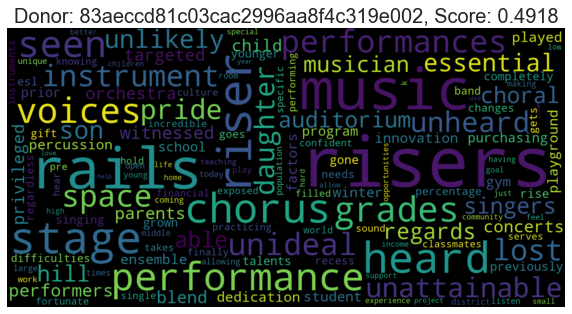

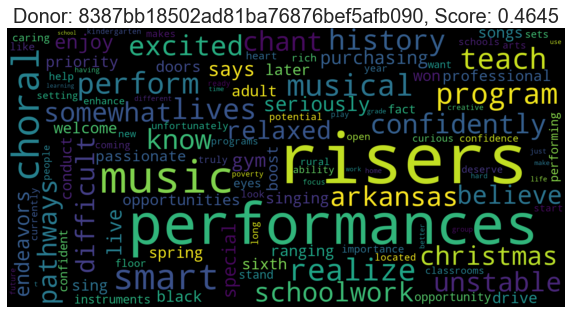

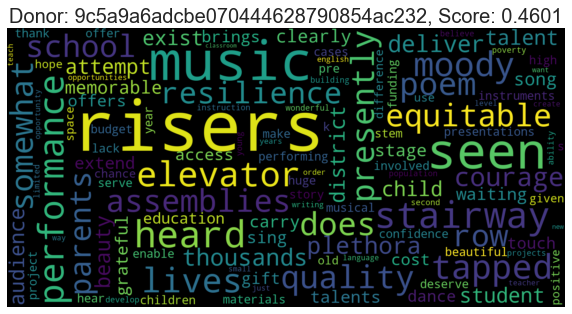

In [17]:
project=projects_test.sample(n=1)
recommended_donors=recommender1.predict(
    project.to_dict('records')[0],
    cut_off_percentile=99.99
)
pd.set_option('display.max_colwidth', -1)
for idx,row in recommended_donors.head(3).iterrows():
    donors_word_cloud(recommender1,row['Donor ID'],row['Score'])
project[recommender1.project_attributes].T

We can see from the above word clouds that the recommended donors are very much relevant to new project description.